In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
# Định nghĩa một neural network với Batch Normalization
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(26, 64) # 26: dữ liệu dùng để huấn luyện có 26 cột
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 2) # Đầu ra 2 cho dự đoán xác suất (có hoặc không)

    def forward(self, x): # Hàm định nghĩa quá trình truyền dữ liệu qua các lớp
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [5]:
torch.manual_seed(42)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
X_train = pd.read_parquet('X_train.parquet')
y_train = pd.read_parquet('y_train.parquet')

X_test = pd.read_parquet('X_test.parquet')
y_test = pd.read_parquet('y_test.parquet')

In [8]:
cols = X_train.columns

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.flatten(), dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values.flatten(), dtype=torch.long).to(device)

In [10]:
# Khởi tạo mô hình neural network và chuyển lên thiết bị
model = Model().to(device)

# Định nghĩa hàm mất mát CrossEntropyLoss và bộ tối ưu hóa Adam
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Huấn luyện mô hình
epochs = 100
losses = []
for epoch in range(epochs):
    # Chuyển mô hình sang chế độ huấn luyện
    model.train()

    # Xóa bộ nhớ cũ
    optimizer.zero_grad()

    # Dự đoán
    outputs = model.forward(X_train_tensor)

    # Tính độ mất mát so với kết quả thực
    loss = loss_function(outputs, y_train_tensor)

    # Lưu lại độ mất mát
    losses.append(loss.detach().cpu().numpy())

    loss.backward()  # Tính gradient
    optimizer.step()  # Cập nhật trọng số

    # In kết quả mỗi 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5563
Epoch [20/100], Loss: 0.4860
Epoch [30/100], Loss: 0.4493
Epoch [40/100], Loss: 0.4278
Epoch [50/100], Loss: 0.4152
Epoch [60/100], Loss: 0.4066
Epoch [70/100], Loss: 0.3998
Epoch [80/100], Loss: 0.3941
Epoch [90/100], Loss: 0.3889
Epoch [100/100], Loss: 0.3840


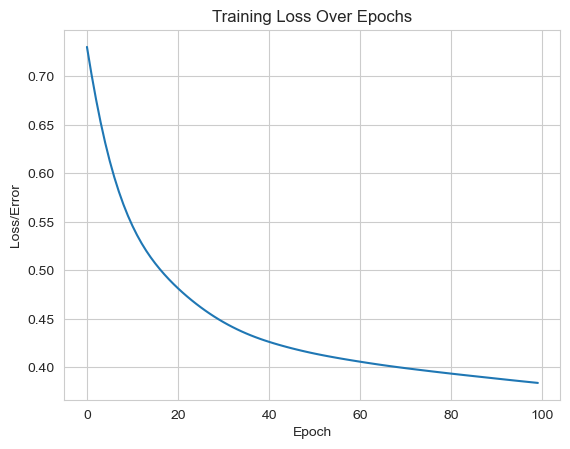

In [12]:
# Vẽ đồ thị độ mất mát qua các epochs
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss/Error')
plt.title('Training Loss Over Epochs')
plt.show()

In [13]:
# Đánh giá mô hình trên tập dữ liệu kiểm tra (validate model on test set)
model.eval()
with torch.no_grad(): # Về cơ bản tắt back propagation (tắt gradient descent)

    # Dự đoán trên tập kiểm tra
    y_eval = model.forward(X_test_tensor) # X_test_tensor là các đặc trưng từ tập kiểm tra, y_eval sẽ là các dự đoán

    # Tính độ mất mát trên tập kiểm tra
    loss = loss_function(y_eval, y_test_tensor)

print(f'Test Loss: {loss.item():.4f}')

Test Loss: 0.4036


In [14]:
correct = 0
# Chuyển mô hình sang chế độ đánh giá
model.eval()
with torch.no_grad():
    for i in range(X_test_tensor.size(0)):
        y_val = model.forward(X_test_tensor[i].unsqueeze(0))  # Thêm unsqueeze(0) để thêm chiều cho dữ liệu
        if y_val.argmax().item() == y_test_tensor[i]:
            correct += 1
print(f'We got {correct}/{y_test.shape[0]}', '(',round((correct / y_test.shape[0] * 100), 2) , '% )', 'correct!')

We got 1147/1409 ( 81.41 % ) correct!


In [15]:
# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Dự đoán trên tập huấn luyện và tập kiểm tra bằng mô hình Neural Network
with torch.no_grad():
    train_preds_nn = model(X_train_tensor.to(device)).cpu().numpy()
    test_preds_nn = model(X_test_tensor.to(device)).cpu().numpy()

# Kết hợp đặc trưng gốc và dự đoán của mô hình Neural Network để tạo đặc trưng mới cho các mô hình
X_train_combined = np.hstack((X_train.values, train_preds_nn))
X_test_combined = np.hstack((X_test.values, test_preds_nn))

# Huấn luyện và dự đoán với Random Forest
rf_model = RandomForestClassifier(
    n_estimators = 1000,
    max_depth = 10,
    min_samples_split = 4,
    min_samples_leaf = 2,
    max_features = 'sqrt',
    bootstrap = True,
    oob_score = True,
    random_state = 42,
    n_jobs = None
)
rf_model.fit(X_train_combined, y_train.values)
print(f'Random Forest Training Accuracy: {rf_model.score(X_train_combined, y_train.values):.4f}')
print(f'Random Forest Test Accuracy: {rf_model.score(X_test_combined, y_test.values):.4f}')

# Thêm mô hình Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators = 200,
    learning_rate = 0.1,
    max_depth = 3,
    min_samples_split = 2,
    min_samples_leaf = 2,
    subsample = 0.8,
    random_state = 42
)
gb_model.fit(X_train_combined, y_train.values)
print(f'Gradient Boosting Training Accuracy: {gb_model.score(X_train_combined, y_train.values):.4f}')
print(f'Gradient Boosting Test Accuracy: {gb_model.score(X_test_combined, y_test.values):.4f}')

Random Forest Training Accuracy: 0.8873
Random Forest Test Accuracy: 0.8098
Gradient Boosting Training Accuracy: 0.8694
Gradient Boosting Test Accuracy: 0.8048


In [16]:
# Hàm tính toán các chỉ số đánh giá
def churn_prediction(algo, train_x, train_y, test_x, test_y, cols, cf = 'coefficients'):
    algo.fit(train_x, train_y)
    predictions = algo.predict(test_x) # Dự đoán nhãn lớp cho tập kiểm tra test_x
    probabilities = algo.predict_proba(test_x)[:, 1] # Dự đoán xác suất cho lớp dương (rời bỏ) trên tập kiểm tra

    # Kiểm tra xem mô hình có thuộc tính 'coef_' hoặc 'feature_importances_' không
    if hasattr(algo, 'coef_') and cf == 'coefficients':
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif hasattr(algo, 'feature_importances_') and cf == 'features':
        coefficients = pd.DataFrame(algo.feature_importances_)
    else:
        coefficients = pd.DataFrame([0] * len(cols))  # Tạo một DataFrame giả nếu không có 'coef_' hoặc 'feature_importances_'

    columns_df = pd.DataFrame(cols)
    coef_sum = pd.merge(coefficients, columns_df, left_index = True, right_index = True, how = 'left')
    coef_sum.columns = ["coefficients", "features"]
    coef_sum = coef_sum.sort_values(by = 'coefficients', ascending = False)

    print(algo)
    print("\nClassification report:\n", classification_report(test_y, predictions))
    print("Accuracy Score:", accuracy_score(test_y, predictions))

    conf_matrix = confusion_matrix(test_y, predictions)
    plt.figure(figsize = (12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d", annot = True, cmap = 'Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    model_roc_auc = roc_auc_score(test_y, probabilities)
    print("Area under curve:", model_roc_auc, "\n")
    fpr, tpr, thresholds = roc_curve(test_y, probabilities)

    churn_rate_prob = np.mean(probabilities)
    churn_rate_pred = np.mean(predictions)

    print(f"Churn rate (based on probabilities): {churn_rate_prob:.2%}")
    print(f"Churn rate (based on predictions): {churn_rate_pred:.2%}")

    plt.subplot(222)
    plt.plot(fpr, tpr, color = 'darkorange', lw = 1, label = "Auc: %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (tỉ lệ giả)')
    plt.ylabel('True Positive Rate (tỉ lệ đúng)')
    plt.title('Biểu đồ đặc trưng')
    plt.legend(loc="lower right")

    plt.subplot(212)
    sns.barplot(x = coef_sum["features"], y = coef_sum["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation = "vertical")

    plt.show()

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=1000, oob_score=True, random_state=42)

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1036
           1       0.66      0.57      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Accuracy Score: 0.8097941802696949
Area under curve: 0.8572282546813378 

Churn rate (based on probabilities): 27.03%
Churn rate (based on predictions): 22.64%


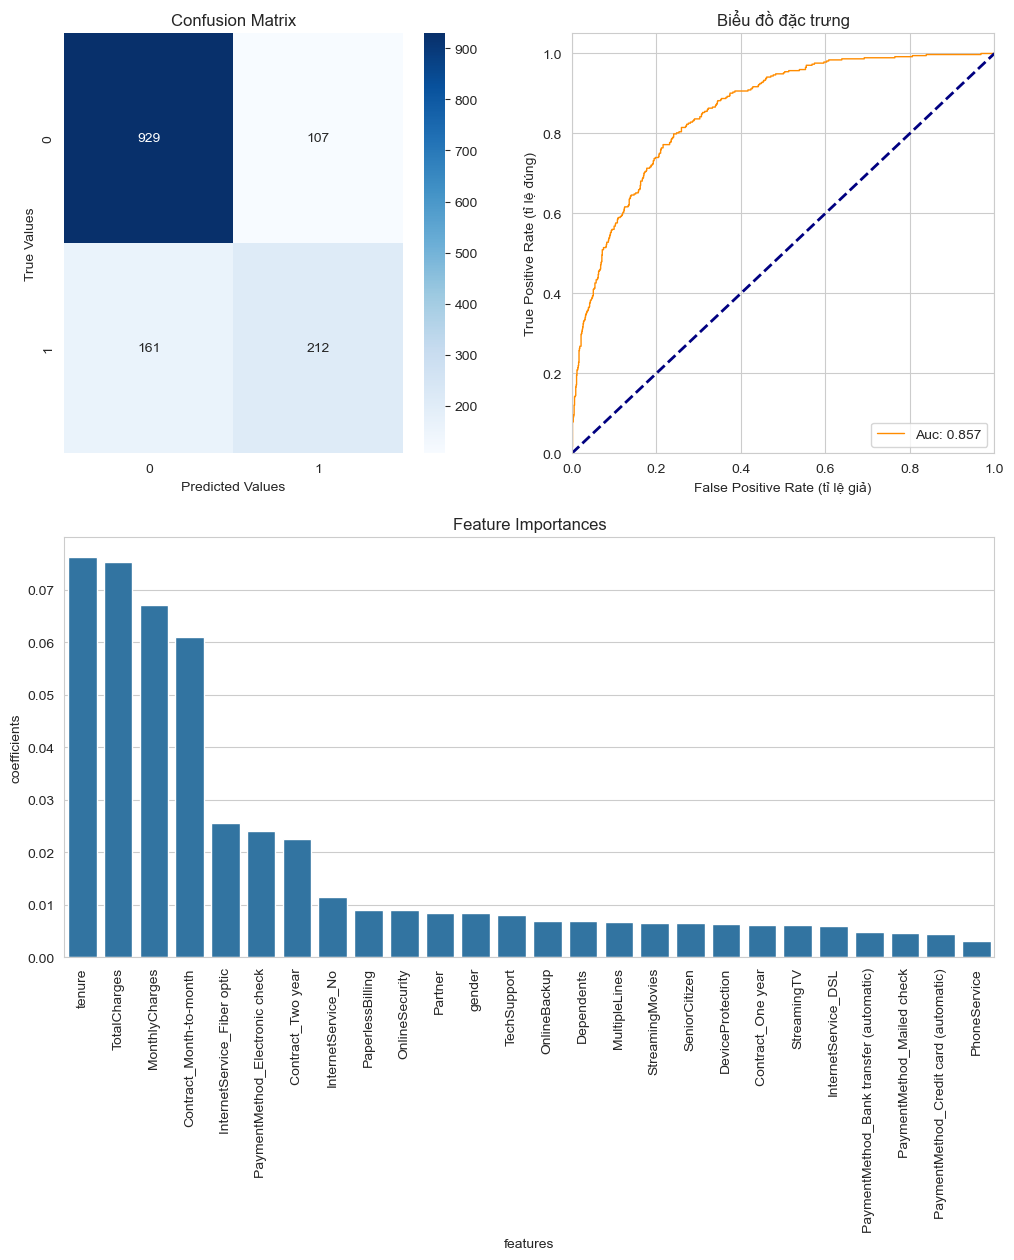

In [17]:
churn_prediction(rf_model, X_train_combined, y_train.values, X_test_combined, y_test.values, cols, cf = 'features')

GradientBoostingClassifier(min_samples_leaf=2, n_estimators=200,
                           random_state=42, subsample=0.8)

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.65      0.57      0.61       373

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409

Accuracy Score: 0.8048261178140526
Area under curve: 0.8450202883848996 

Churn rate (based on probabilities): 27.03%
Churn rate (based on predictions): 23.00%


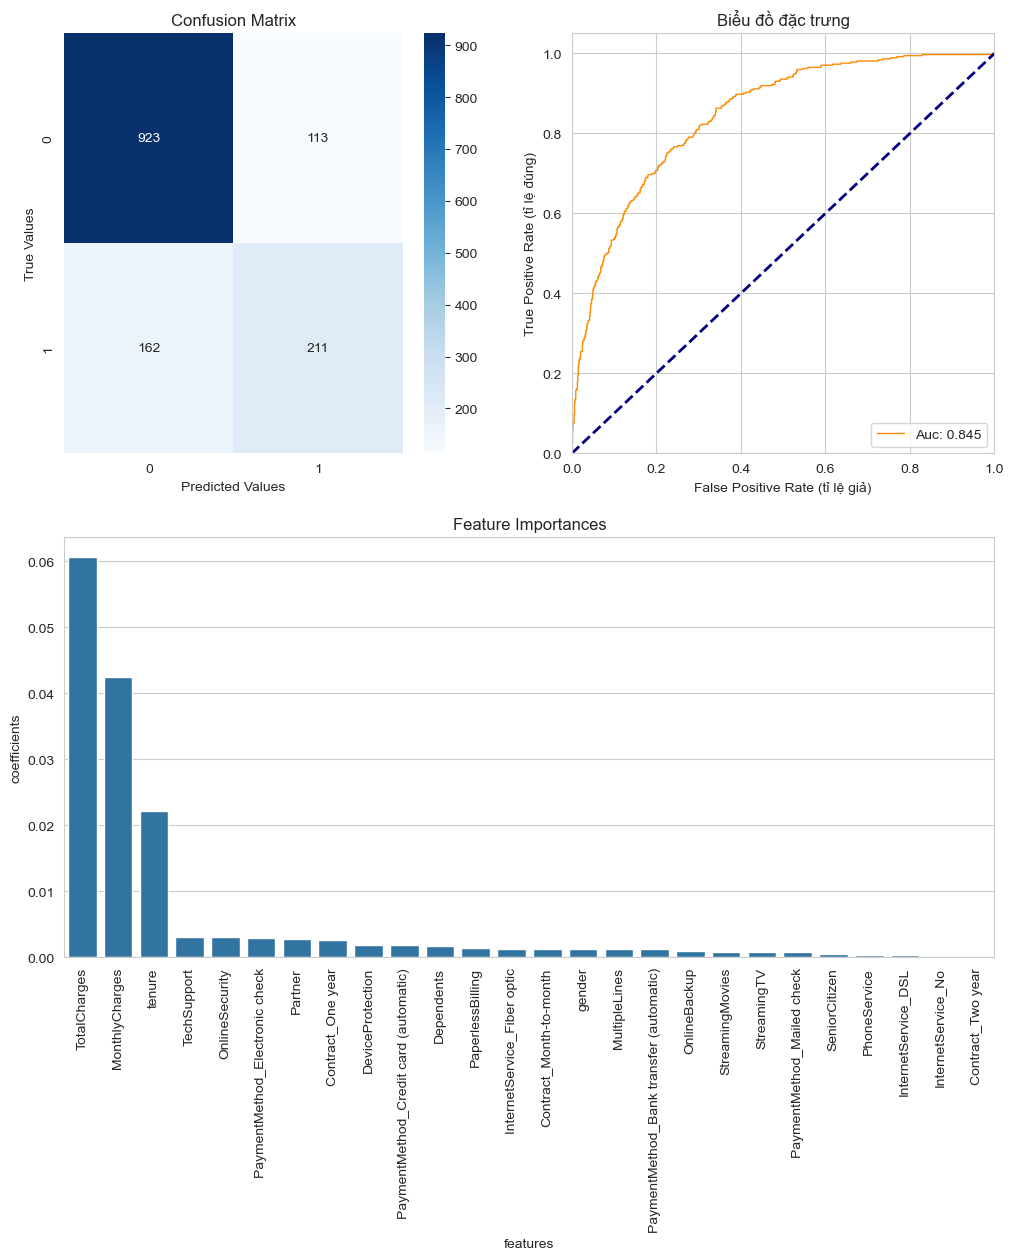

In [18]:
churn_prediction(gb_model, X_train_combined, y_train.values, X_test_combined, y_test.values, cols, cf = 'features')

In [19]:
!pip install --upgrade lazypredict-nightly --quiet

In [20]:
import lazypredict

In [21]:
from lazypredict import LazyClassifier

In [22]:
lazy_classifier = LazyClassifier()

# Fit the models and evaluate with X_train_scaled and y_train
models, predictions = lazy_classifier.fit(X_train_combined, X_test_combined, y_train.values, y_test.values)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:08<00:00,  3.71it/s]

[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418


In [23]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.76,0.78,0.78,0.78,0.03
NearestCentroid,0.76,0.78,0.78,0.77,0.02
BernoulliNB,0.76,0.78,0.78,0.77,0.04
QuadraticDiscriminantAnalysis,0.74,0.76,0.76,0.76,0.03
SVC,0.81,0.73,0.73,0.81,0.94
AdaBoostClassifier,0.80,0.73,0.73,0.80,0.26
SGDClassifier,0.79,0.73,0.73,0.79,0.03
LinearDiscriminantAnalysis,0.80,0.73,0.73,0.80,0.05
RidgeClassifier,0.81,0.73,0.73,0.80,0.03


In [24]:
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'], \
          colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], Probability=1, fname=False): 
    
    N = len(labels)
    colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(4)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, 'Churn Probability ' + np.round(Probability,2).astype(str), horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = (1-Probability)*180
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

Actual value: [1]
Predicted probability of churning: 0.7225


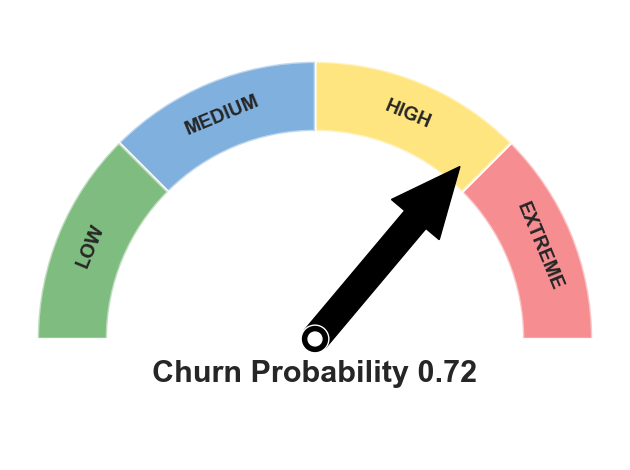

In [53]:
actual_value = y_test.values[545]
predicted_probability = gb_model.predict_proba(X_test_combined[545:546])[0, 1]
print(f"Actual value: {actual_value}")
print(f"Predicted probability of churning: {predicted_probability:.4f}")
gauge(Probability=predicted_probability)

Số lượng khách hàng theo xác suất rời bỏ:
0-10%: 605
10-20%: 168
20-30%: 132
30-40%: 96
40-50%: 84
50-60%: 85
60-70%: 73
70-80%: 65
80-90%: 49
90-100%: 52

Tổng số khách hàng: 1409

Phần trăm khách hàng theo xác suất rời bỏ:
0-10%: 42.94%
10-20%: 11.92%
20-30%: 9.37%
30-40%: 6.81%
40-50%: 5.96%
50-60%: 6.03%
60-70%: 5.18%
70-80%: 4.61%
80-90%: 3.48%
90-100%: 3.69%


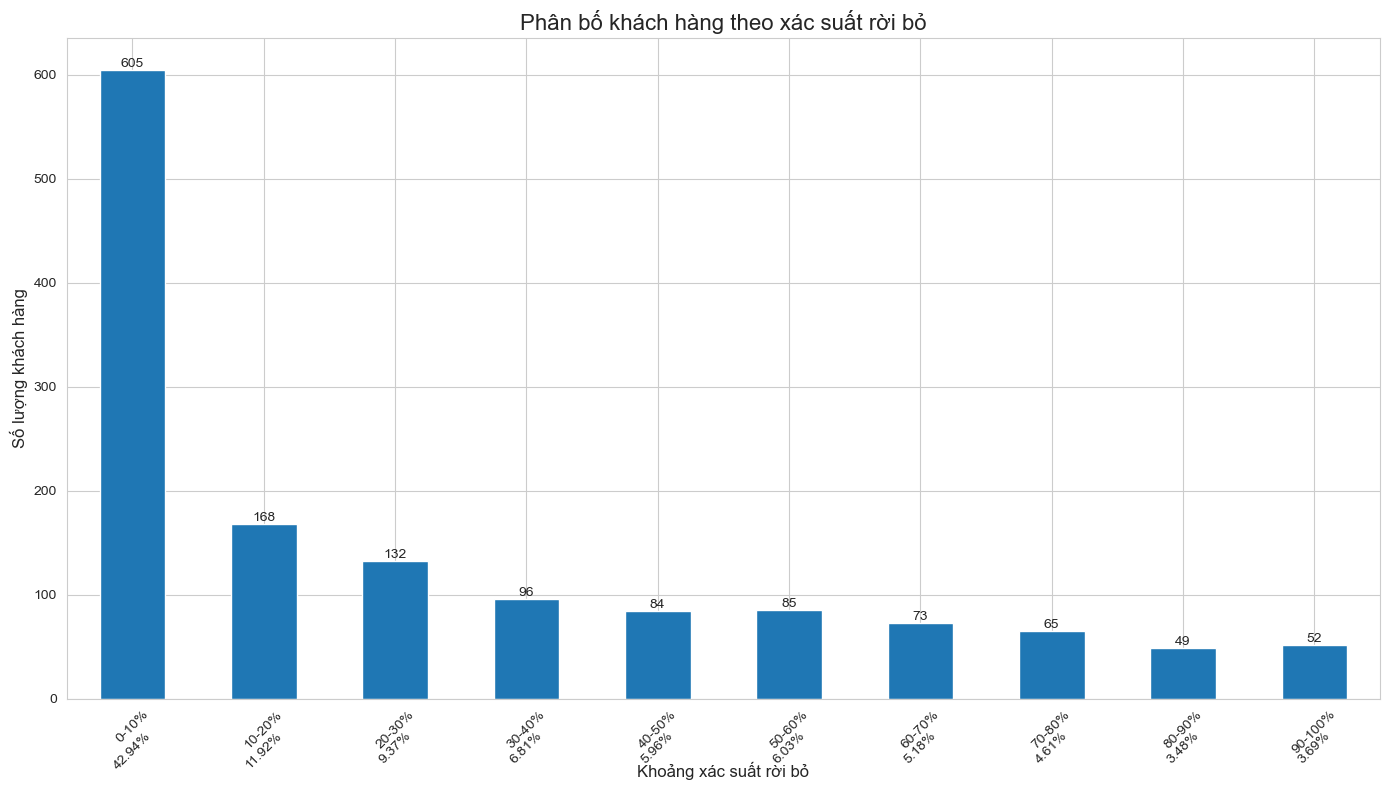

In [50]:
# Dự đoán xác suất churn cho toàn bộ dataset
probabilities = gb_model.predict_proba(X_test_combined)[:, 1]

# Tạo DataFrame chứa xác suất churn
results = pd.DataFrame({
    'churn_probability': probabilities
})

# Tạo các khoảng xác suất
bins = [i/10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
labels = [f'{i*10}-{(i+1)*10}%' for i in range(10)]  # ['0-10%', '11-20%', ..., '91-100%']

# Phân loại xác suất vào các khoảng
results['probability_range'] = pd.cut(results['churn_probability'], bins=bins, labels=labels, include_lowest=True)

# Đếm số lượng khách hàng trong mỗi khoảng
count_by_range = results['probability_range'].value_counts().sort_index()

# In kết quả
print("Số lượng khách hàng theo xác suất rời bỏ:")
for range_label, count in count_by_range.items():
    print(f"{range_label}: {count}")

# Tính tổng số khách hàng
total_customers = len(results)
print(f"\nTổng số khách hàng: {total_customers}")

# Tính phần trăm
percentage_by_range = (count_by_range / total_customers * 100).round(2)

print("\nPhần trăm khách hàng theo xác suất rời bỏ:")
for range_label, percentage in percentage_by_range.items():
    print(f"{range_label}: {percentage}%")

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
ax = count_by_range.plot(kind='bar')
plt.title('Phân bố khách hàng theo xác suất rời bỏ', fontsize=16)
plt.xlabel('Khoảng xác suất rời bỏ', fontsize=12)
plt.ylabel('Số lượng khách hàng', fontsize=12)
plt.xticks(rotation=45)

# Thêm số lượng chi tiết trên đầu mỗi cột
for i, v in enumerate(count_by_range):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Thêm phần trăm dưới nhãn trục x
for i, (range_label, percentage) in enumerate(percentage_by_range.items()):
    ax.text(i, -max(count_by_range)*0.05, f'{percentage}%', ha='center', va='top', rotation=45)

plt.tight_layout()
plt.show()